<a href="https://colab.research.google.com/github/hamagami/ad2025/blob/main/%E6%99%82%E7%B3%BB%E5%88%97%E7%A7%BB%E5%8B%95%E5%B9%B3%E5%9D%87%E3%81%AB%E3%82%88%E3%82%8B%E7%95%B0%E5%B8%B8%E6%A4%9C%E7%9F%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

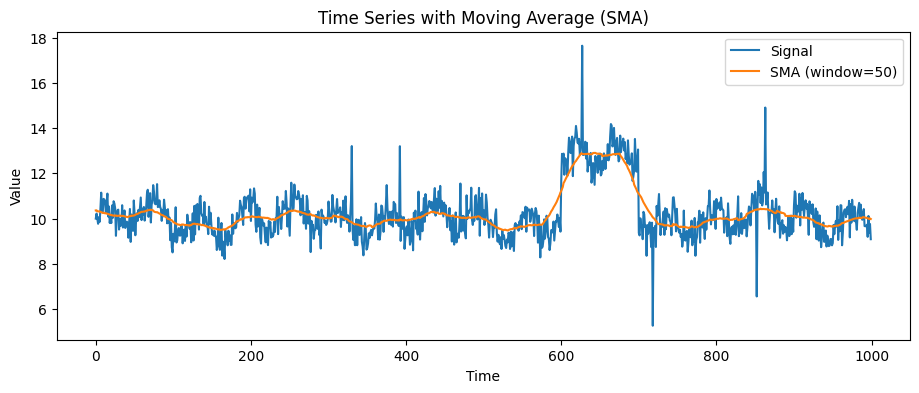

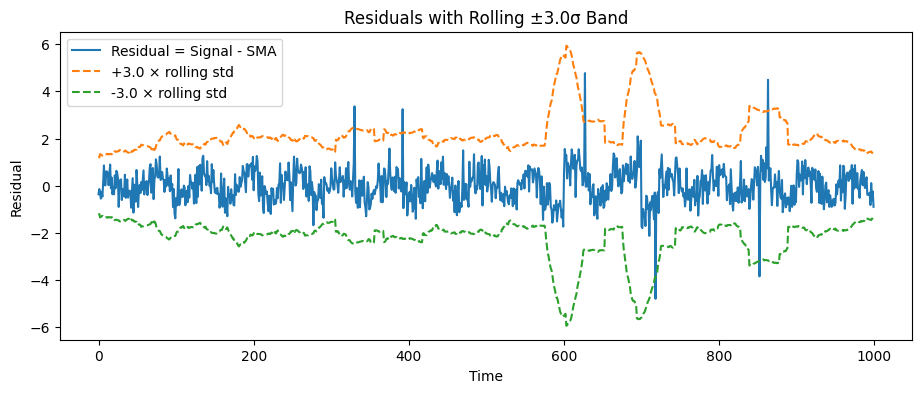

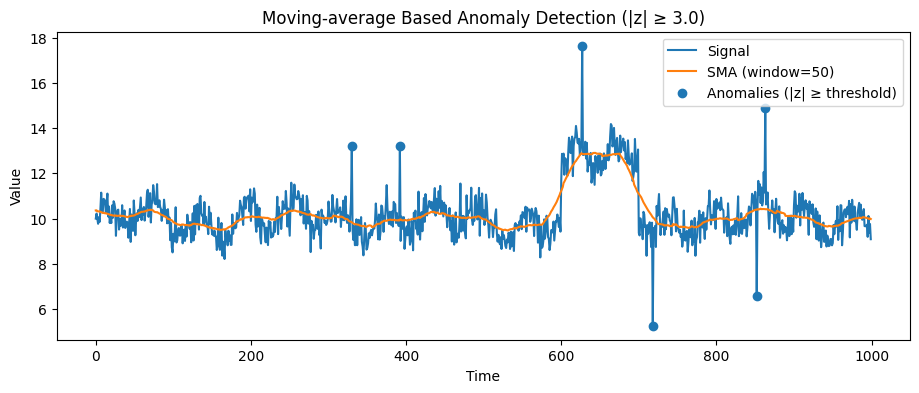

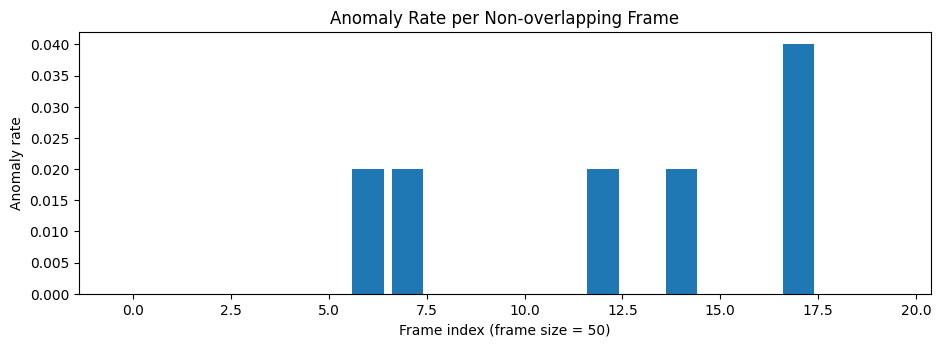

Detected anomalies: 6 / 1000


,t,value,zscore
0,330,13.205601,4.077055
1,392,13.199526,4.311179
2,627,17.640467,5.233928
3,718,5.267561,-3.703511
4,852,6.560752,-3.606867


Saved: signal.csv, sma.csv, rolling_zscore.csv, anomalies_mavg.csv


In [1]:
# Colab-ready: Moving-average (frame) based anomaly detection
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===== Parameters =====
N = 1000          # length of time series
SEED = 7          # RNG seed
WINDOW = 50       # frame/window size for moving stats
K = 3.0           # threshold multiplier (|z| >= K)
INJECT_DEMO_ANOMALIES = True  # add spikes/level-shift to demo

# ===== 0) Generate demo time series =====
rng = np.random.default_rng(SEED)
t = np.arange(N)

# baseline: level + low-amplitude seasonality + Gaussian noise
y = 10 + 0.6*np.sin(2*np.pi*t/60) + 0.35*np.sin(2*np.pi*t/200) + rng.normal(0, 0.5, size=N)

# optional: inject anomalies (spikes + level shift)
if INJECT_DEMO_ANOMALIES:
    spike_idx = rng.choice(np.arange(100, 900), size=8, replace=False)
    y[spike_idx] += rng.normal(4.0, 1.0, size=spike_idx.size) * rng.choice([1,-1], size=spike_idx.size)
    # level shift segment
    y[600:700] += 2.5

s = pd.Series(y, index=pd.RangeIndex(N, name="t"))

# ===== 1) Rolling (frame) mean & std (SMA) =====
roll = s.rolling(window=WINDOW, center=True, min_periods=WINDOW//2)
mu = roll.mean()
sigma = roll.std(ddof=0)

# avoid division by zero
sigma = sigma.replace(0, np.nan)

# residuals and rolling z-score
resid = s - mu
z = resid / sigma

# anomaly rule: |z| >= K (only where rolling stats exist)
anomaly_mask = (z.abs() >= K)

# ===== 2) Plots =====

# Figure 1: raw series + moving average
plt.figure(figsize=(11, 4))
plt.plot(s.index, s.values, label="Signal")
plt.plot(mu.index, mu.values, label=f"SMA (window={WINDOW})")
plt.title("Time Series with Moving Average (SMA)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend(loc="best")
plt.show()

# Figure 2: residuals with ±K*std band
plt.figure(figsize=(11, 4))
plt.plot(resid.index, resid.values, label="Residual = Signal - SMA")
plt.plot(sigma.index,  K*sigma, linestyle="--", label=f"+{K} × rolling std")
plt.plot(sigma.index, -K*sigma, linestyle="--", label=f"-{K} × rolling std")
plt.title(f"Residuals with Rolling ±{K}σ Band")
plt.xlabel("Time")
plt.ylabel("Residual")
plt.legend(loc="best")
plt.show()

# Figure 3: anomalies on the original signal
plt.figure(figsize=(11, 4))
plt.plot(s.index, s.values, label="Signal")
plt.plot(mu.index, mu.values, label=f"SMA (window={WINDOW})")
plt.scatter(s.index[anomaly_mask], s.values[anomaly_mask],
            label="Anomalies (|z| ≥ threshold)", marker="o")
plt.title(f"Moving-average Based Anomaly Detection (|z| ≥ {K})")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend(loc="best")
plt.show()

# ===== 3) Optional: frame-level summary (non-overlapping windows) =====
# Count anomalies per non-overlapping frame of length WINDOW
frame_id = (s.index // WINDOW).astype(int)
frame_summary = (
    pd.DataFrame({
        "frame": frame_id,
        "is_anomaly": anomaly_mask.fillna(False).astype(bool)
    })
    .groupby("frame")["is_anomaly"].agg(["sum","count"])
    .rename(columns={"sum":"anomaly_count", "count":"frame_size"})
    .reset_index()
)
frame_summary["anomaly_rate"] = frame_summary["anomaly_count"] / frame_summary["frame_size"]

plt.figure(figsize=(11, 3.4))
plt.bar(frame_summary["frame"], frame_summary["anomaly_rate"])
plt.title("Anomaly Rate per Non-overlapping Frame")
plt.xlabel(f"Frame index (frame size = {WINDOW})")
plt.ylabel("Anomaly rate")
plt.show()

# ===== 4) Outputs =====
anomalies_df = pd.DataFrame({
    "t": s.index[anomaly_mask],
    "value": s[anomaly_mask].values,
    "zscore": z[anomaly_mask].values
}).reset_index(drop=True)

print(f"Detected anomalies: {anomalies_df.shape[0]} / {len(s)}")
display(anomalies_df.head())

# Save CSVs (optional)
s.rename("value").to_csv("signal.csv", index_label="t")
mu.rename("sma").to_csv("sma.csv", index_label="t")
z.rename("zscore").to_csv("rolling_zscore.csv", index_label="t")
anomalies_df.to_csv("anomalies_mavg.csv", index=False)
print("Saved: signal.csv, sma.csv, rolling_zscore.csv, anomalies_mavg.csv")

# ===== 5) (Optional) Exponential Moving Average version =====
# Uncomment to use EMA (EWMA) instead of SMA:
# alpha = 2/(WINDOW+1)
# ema = s.ewm(alpha=alpha, adjust=False).mean()
# # Use rolling std still (or ewm std: s.ewm(alpha=alpha).std(bias=False))
# z_ema = (s - ema) / sigma
# anomaly_mask_ema = z_ema.abs() >= K
